In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os.path as osp
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from pykeen.evaluation import RankBasedEvaluator
from pykeen.triples import TriplesFactory
import torch
from tqdm import tqdm
import json
import numpy as np
from typing import List
from typing import List, Union


/home/jovyan/.conda/envs/bioblp-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from nb_utils.eval_utils import TEST, VALID, TRAIN, TEST_EXCLUDING_DIS, TEST_RESTRICTED_DIS
from nb_utils.eval_utils import COL_SOURCE, COL_TARGET, COL_EDGE, COL_NODE, DEGREE, IN_DEGREE, OUT_DEGREE
from nb_utils.eval_utils import obtain_filtered_triples, split_test_triples_conditioned_on_ent_property, split_train_ents_by_existance_of_properties
from nb_utils.eval_utils import setup_wandb_result_tracker, run_experiment_and_log_wandb
from nb_utils.eval_utils import make_results_dict_all_rel, make_results_dict_rel_breakdown

Change this cell to generate a report for other datasets/models:

In [4]:
SHARED_DATA_DIR = Path("/home/jovyan/workbench-shared-folder/bioblp")
PROJ_DATA_DIR = Path("../data/")

In [5]:
# model registry
ROTATE = "rotate"
BIOBLP_D = "bioblp_d"

MODEL_ID_rotate = 'rotate-otxtubeb' 
MODEL_ID_bioblpd = 'bioblpd-38uz9fjs'

MODELS = {
    ROTATE: MODEL_ID_rotate,
    BIOBLP_D: MODEL_ID_bioblpd
}

In [6]:
model_registry_basedir = SHARED_DATA_DIR.joinpath(f"models")
model_registry_paths = {v: model_registry_basedir.joinpath(f"{v}") for v in MODELS.values()}
model_registry_paths

{'rotate-otxtubeb': PosixPath('/home/jovyan/workbench-shared-folder/bioblp/models/rotate-otxtubeb'),
 'bioblpd-38uz9fjs': PosixPath('/home/jovyan/workbench-shared-folder/bioblp/models/bioblpd-38uz9fjs')}

##  Loading model and data

make a keyword based switching statement b/w rotate and bioblp-d

In [7]:
def load_kge_model(model_base_path):
    model_path = model_base_path.joinpath("trained_model.pkl")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torch.load(model_path, map_location=torch.device(device))
    #train = TriplesFactory.from_path_binary(model_base_path.joinpath("training_triples"))
    return model
    

In [8]:
# load rotate, or bioblp-d
MODEL_ID = MODELS.get(ROTATE)    
model = load_kge_model(model_base_path = model_registry_paths[MODEL_ID])
train = TriplesFactory.from_path_binary(model_registry_paths[MODEL_ID].joinpath("training_triples"))

In [9]:
graph_path = PROJ_DATA_DIR.joinpath('biokgb/graph')
valid_triples = 'biokg.links-valid.csv'
test_triples = 'biokg.links-test.csv'
dummy_triples = 'biokg.links-dummy.csv'

creating a dummy set of triples for unit testing purposes

In [10]:
DUMMY = 'dummy'
dummy_triples = 'biokg.links-dummy.csv'
dummy_df = pd.read_csv(graph_path.joinpath(test_triples), sep="\t", header=None)[:50]
dummy_df.to_csv(graph_path.joinpath(dummy_triples), sep="\t", index=None, header=None)

In [11]:
valid, test, dummy = [TriplesFactory.from_path(graph_path.joinpath(f),
                                        entity_to_id=train.entity_to_id,
                                        relation_to_id=train.relation_to_id)
               for f in (valid_triples, test_triples, dummy_triples)]

#### Split test triples conditional on whether they contain entities whose properties were encoded in BIOBLP-X vs not

Create test sets: 
D; D_b, D_r; 

All biokgb entities surprisingly have a relation - > D_r is an empty set. -> This is because we used teh name of disease as decription in places where it was missing

In [12]:
#disease_descr_path = PROJ_DATA_DIR.joinpath("biokgb/properties/biokg_meshid_to_descr_name-orig.tsv")
disease_descr_path = PROJ_DATA_DIR.joinpath("biokgb/properties/biokg_meshid_to_descr_name.tsv")
disease_metadata_path = PROJ_DATA_DIR.joinpath("biokgb/properties/biokg.metadata.disease.tsv")

# create a subset of biokg entities of type Disease 
diseases = pd.read_csv(disease_metadata_path, sep="\t", names=["disease", "rel", "node_type"])
disease_set = set(diseases.disease.values)
print(f"# Disease entities in larger biokg (pre-benchmark removal): {len(disease_set)}")

# create a set of disease entities for which we have text descriptions
disease_w_desc_df = pd.read_csv(disease_descr_path, sep="\t", header=0, names=["disease", "desc"])
disease_desc_set = set(disease_w_desc_df.disease.values)
print(f"# Disease entities in larger biokg (pre-benchmark removal) for which we have textual descriptions: {len(disease_desc_set)}")


# Disease entities in larger biokg (pre-benchmark removal): 11347
# Disease entities in larger biokg (pre-benchmark removal) for which we have textual descriptions: 11347


In [13]:
# Side note: all disease entities in Biokgb have decscriptions; because missing values were plugged with disease names
disease_w_desc_df["len"] = disease_w_desc_df["desc"].str.len()
disease_w_desc_df.len.describe()

count    11347.000000
mean       149.042743
std        156.370558
min          5.000000
25%         37.000000
50%         70.000000
75%        231.000000
max       1076.000000
Name: len, dtype: float64

#### define test sets

In [15]:
test_triples_incl_dis_prop, test_triples_excl_dis_prop = split_test_triples_conditioned_on_ent_property(train_triples=train, 
                                                                                                        typed_ent_set=disease_set, 
                                                                                                        typed_ent_with_prop_set=disease_desc_set,
                                                                                                        test_triples=test)

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


In [16]:
# relations containing diseases include -> 
dis_assoc_rels = {rel:rel_id for rel, rel_id in train.relation_to_id.items() if 'DISEASE' in rel}
dis_assoc_rels

{'DISEASE_GENETIC_DISORDER': 3,
 'DISEASE_PATHWAY_ASSOCIATION': 4,
 'DRUG_DISEASE_ASSOCIATION': 7,
 'PROTEIN_DISEASE_ASSOCIATION': 14}

In [17]:
# equivalence of test_triples restricted on disease- assoc relationships and test_triples_incl_dis_prop above
#test_triples_disease = test.new_with_restriction(relations=list(dis_assoc_rels.values()))

In [18]:
# create set of triples
print(f"# triples originally in test: {test.num_triples}, valid: {valid.num_triples}")
#test_triples_disease = test.new_with_restriction(relations=list(dis_assoc_rels.values()))
#valid_triples_disease = valid.new_with_restriction(relations=list(dis_assoc_rels.values()))
print(f"# test triples with disease nodes: {test_triples_incl_dis_prop.num_triples}")
print(f"# valid triples with disease nodes: {test_triples_excl_dis_prop.num_triples}")


# triples originally in test: 185227, valid: 185226
# test triples with disease nodes: 17063
# valid triples with disease nodes: 168164


In [19]:
triples_dict = {
    TEST: test,
    VALID: valid,
    TRAIN: train,
    TEST_RESTRICTED_DIS: test_triples_incl_dis_prop,
    TEST_EXCLUDING_DIS: test_triples_excl_dis_prop,
    DUMMY: dummy, 
}

TEST_SET_LIST = [TEST_RESTRICTED_DIS, TEST_EXCLUDING_DIS, TEST, VALID]


# Evaluation

wandb logging

In [ ]:
import wandb
wandb.login()

WANDB_ENTITY_DISCOVERYLAB = "discoverylab"
WANDB_PROJECT_NAME = "bioblp-jupyter-trial"


sanity check logic for experiment run with wandb logging

In [22]:
def trial_func(x=1, y=2):
    print(x*y)
    return {'x': x, 'y':y}

#trial_func_kwargs = {"x": 1, "y": 2} 
#metrics = run_experiment('dummy-run', TEST, BIOBLP_D, trial_func, **trial_func_kwargs) 

### LP performace: Micro averaged metrics across All Relations

In [74]:
def evaluate_lp_on_single_test_set(model, eval_test_set_slug, all_rels=True, split_by_rels=False):

    evaluator = RankBasedEvaluator(filtered=True)   
    # should we filtering more triples in the disease restricted test sets?
    filtered_triples = obtain_filtered_triples(test_type=eval_test_set_slug, 
                                               train_triples=triples_dict.get(TRAIN),
                                               valid_triples=triples_dict.get(VALID)
                                              )
    eval_result = evaluator.evaluate(model, triples_dict[eval_test_set_slug].mapped_triples,
                                     additional_filter_triples = filtered_triples)
    
    results_all_rels = make_results_dict_all_rel(eval_result, 
                                         relation='All', 
                                         relation_count=triples_dict.get(eval_test_set_slug).num_triples)
    
    # if split_by_rels: to add logic 
        
    return results_all_rels
        

In [36]:
# dummy run
dummy_func_kwargs = {"model": model, "eval_test_set_slug": DUMMY}
dummy_results = evaluate_lp_on_single_test_set(**dummy_func_kwargs)
'''
results_microavg_test_retricted_dis = run_experiment_and_log_wandb(study_name='dummy-run-eval', 
                   test_set_slug=TEST_RESTRICTED_DIS, 
                   model_name=MODEL_ID, 
                   eval_func=evaluate_lp_on_single_test_set, 
                   **func_kwargs
                  )
'''


Evaluating on cuda:0: 100%|██████████| 50.0/50.0 [00:00<00:00, 63.0triple/s]


"\nresults_microavg_test_retricted_dis = run_experiment_and_log_wandb(study_name='dummy-run-eval', \n                   test_set_slug=TEST_RESTRICTED_DIS, \n                   model_name=MODEL_ID, \n                   eval_func=evaluate_lp_on_single_test_set, \n                   **func_kwargs\n                  )\n"

In [75]:
def run_wandb_eval_all_rels_on_multiple_test_sets(model_id: str,
                                                  test_set_list: List[str],
                                                  eval_out_dir: Union[Path, str],
                                                  wandb_project_name=WANDB_PROJECT_NAME):
    micro_results_dicts = {}
    STUDY_EVAL_MICRO_AVG = 'eval-micro-avg'
    study_name = STUDY_EVAL_MICRO_AVG
    eval_out_dir = Path(eval_out_dir)
    eval_out_dir.mkdir(exist_ok=True , parents=True)

    model = load_kge_model(model_registry_paths.get(model_id))
    
    for test_set_slug in test_set_list:
        print(f"Model being evaluated: {model_id}, of type {type(model)}")
        func_kwargs = {"model": model, "eval_test_set_slug": test_set_slug}

        rel_results = run_experiment_and_log_wandb(study_name=study_name, 
                                                   test_set_slug=test_set_slug, 
                                                   model_name=MODEL_ID, 
                                                   eval_func=evaluate_lp_on_single_test_set, 
                                                   wandb_project_name=wandb_project_name,
                                                   **func_kwargs
                                                  )
        micro_results_dicts[test_set_slug] = rel_results

    with open(eval_out_dir.joinpath(f'{study_name}.json'), 'w+') as f:
        json.dump(micro_results_dicts, f)

In [60]:
# parameterise MODEL_NAME_SLUG as single point of entry into chain of model related parameters
MODEL_NAME_SLUG = ROTATE
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
DUMMY_TEST_LIST = [DUMMY]
eval_out_dir = Path(f"./metrics/{MODEL_ID}")

run_wandb_eval_all_rels_on_multiple_test_sets(model_id=MODEL_ID,
                                             test_set_list=DUMMY_TEST_LIST,
                                             eval_out_dir=eval_out_dir,
                                             wandb_project_name=WANDB_PROJECT_NAME)

Model being evaluated: rotate-otxtubeb, of type <class 'pykeen.models.unimodal.rotate.RotatE'>


Evaluating on cuda:0: 100%|██████████| 50.0/50.0 [00:00<00:00, 60.6triple/s]


In [ ]:
MODEL_NAME_SLUG = BIOBLPD
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
DUMMY_TEST_LIST = [DUMMY]
eval_out_dir = Path(f"./metrics/{MODEL_ID}")

run_wandb_eval_all_rels_on_multiple_test_sets(model_id=MODEL_ID,
                                             test_set_list=TEST_SET_LIST,
                                             eval_out_dir=eval_out_dir)

In [25]:
model_name = MODEL_ID
for test_set_slug in TEST_SET_LIST:
    func_kwargs = {"model": model, "eval_test_set_slug": test_set_slug}

    run_experiment(study_name='eval-micro-avg', 
                   test_set_slug=test_set_slug, 
                   model_name=model_name, 
                   eval_func=evaluate_lp_on_single_test_set, 
                   **func_kwargs
                  )

Evaluating on cuda:0: 100%|██████████| 17.1k/17.1k [02:55<00:00, 97.0triple/s]


Evaluating on cuda:0: 100%|██████████| 168k/168k [29:10<00:00, 96.1triple/s] 


Evaluating on cuda:0: 100%|██████████| 185k/185k [32:09<00:00, 96.0triple/s] 


Evaluating on cuda:0: 100%|██████████| 185k/185k [31:44<00:00, 97.3triple/s] 


## analyse effect of node degree?
1. compute a degree table for entities in train

In [20]:
training_df = pd.DataFrame(train.triples, columns=[COL_SOURCE, COL_EDGE, COL_TARGET])
training_df[:2]

Reconstructing all label-based triples. This is expensive and rarely needed.


,src,rel,tgt
0,A0A075B6P5,MEMBER_OF_COMPLEX,R-HSA-1479277
1,A0A075B6P5,MEMBER_OF_COMPLEX,R-HSA-1591211


In [21]:
# not a nec step, but to ease computation, let's restrict the triples to disease node containg triples
training_df = training_df[training_df[COL_EDGE].isin(list(dis_assoc_rels.keys()))]
training_df.rel.value_counts()

PROTEIN_DISEASE_ASSOCIATION    89804
DRUG_DISEASE_ASSOCIATION       53426
DISEASE_GENETIC_DISORDER        4339
DISEASE_PATHWAY_ASSOCIATION     2945
Name: rel, dtype: int64

In [22]:
def compute_node_degrees(triple_df):
    out_degree_df = training_df.groupby(COL_SOURCE)[COL_EDGE].agg("count").reset_index()
    out_degree_df.rename(columns={COL_SOURCE: COL_NODE, COL_EDGE: OUT_DEGREE}, inplace=True)
    in_degree_df = training_df.groupby(COL_TARGET)[COL_EDGE].agg("count").reset_index()
    in_degree_df.rename(columns={COL_TARGET: COL_NODE, COL_EDGE: IN_DEGREE}, inplace=True)
    node_degree_df = out_degree_df.merge(in_degree_df, on=COL_NODE, how="outer")
    node_degree_df = node_degree_df.fillna(0)
    node_degree_df[DEGREE] = node_degree_df.in_degree+node_degree_df.out_degree
    node_degree_df = node_degree_df.fillna(0)
    return node_degree_df


In [23]:
node_degree_df = compute_node_degrees(training_df)

In [24]:
node_degree_df["is_disease"] = node_degree_df[COL_NODE].apply(lambda x: x in disease_set)
dis_node_degree_df = node_degree_df[node_degree_df.is_disease]
dis_node_degree_df[:2]

,ent,out_degree,in_degree,degree,is_disease
666,C000600608,4.0,4.0,8.0,True
678,C531816,5.0,7.0,12.0,True


In [25]:
# now bucket the test triples according to node degree
dis_degree_dict = pd.Series(dis_node_degree_df.degree.values,index=dis_node_degree_df.ent).to_dict()
test_triples_dis_df = pd.DataFrame(test_triples_incl_dis_prop.triples, columns=["src", "rel", "tgt"])
def retrieve_node_degree(node, node2degree_dict):
    return node2degree_dict.get(node, 0)

test_triples_dis_df["src_dis_degree"] = test_triples_dis_df["src"].apply(lambda x: retrieve_node_degree(x, dis_degree_dict))
test_triples_dis_df["tgt_dis_degree"] = test_triples_dis_df["tgt"].apply(lambda x: retrieve_node_degree(x, dis_degree_dict))
test_triples_dis_df["dis_degree"] = test_triples_dis_df.src_dis_degree + test_triples_dis_df.tgt_dis_degree
test_triples_dis_df[:3]  
test_triples_dis_df.head()

Reconstructing all label-based triples. This is expensive and rarely needed.


,src,rel,tgt,src_dis_degree,tgt_dis_degree,dis_degree
0,A0A0G2K344,PROTEIN_DISEASE_ASSOCIATION,D000077192,0.0,464.0,464.0
1,A0A0G2K344,PROTEIN_DISEASE_ASSOCIATION,D000077274,0.0,56.0,56.0
2,A0A0G2K344,PROTEIN_DISEASE_ASSOCIATION,D009062,0.0,180.0,180.0
3,A0A0R4IKU3,PROTEIN_DISEASE_ASSOCIATION,D009361,0.0,599.0,599.0
4,A0A0R4IQZ2,PROTEIN_DISEASE_ASSOCIATION,D000686,0.0,38.0,38.0


In [26]:
test_triples_dis_df.dis_degree.describe()

count    17063.000000
mean       300.116451
std        422.864546
min          1.000000
25%         46.000000
50%        144.000000
75%        377.000000
max       2448.000000
Name: dis_degree, dtype: float64

### average performance predicting the node which has an entity degree of x

Let's focus only on 'PROTEIN_DISEASE_ASSOCIATION', 'DRUG_DISEASE_ASSOCIATION' which have more support.

The disease entity is the tail entity in these triples

In [28]:
test_triples_dis_tail_df = test_triples_dis_df.loc[test_triples_dis_df[COL_EDGE].isin(['PROTEIN_DISEASE_ASSOCIATION', 'DRUG_DISEASE_ASSOCIATION'])]
test_triples_dis_tail_df[:2]

,src,rel,tgt,src_dis_degree,tgt_dis_degree,dis_degree
0,A0A0G2K344,PROTEIN_DISEASE_ASSOCIATION,D000077192,0.0,464.0,464.0
1,A0A0G2K344,PROTEIN_DISEASE_ASSOCIATION,D000077274,0.0,56.0,56.0


In [29]:
dis_degree_values = test_triples_dis_df["dis_degree"].unique()
dis_degree_values[0]

464.0

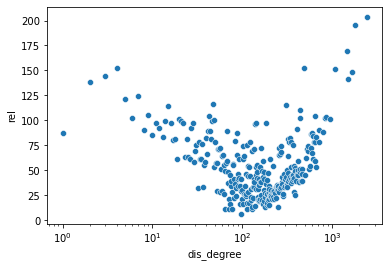

In [30]:
import seaborn as sns
disease_degrees = test_triples_dis_tail_df.groupby(['dis_degree'])[COL_EDGE].agg('count').reset_index()
sns.scatterplot(data=disease_degrees, x='dis_degree', y='rel')
plt.xscale('log')
#plt.yscale('log')

In [31]:
def extract_relevant_metrics(metric_name, results_by_node_degree_dict):
    degrees = list(results_by_node_degree_dict.keys())
    metrics = []
    for deg, metric in results_by_node_degree_dict.items():
        metrics.append(metric[metric_name])
    return degrees, metrics
    
def plot_metric_vs_degree_scatterplot_single_model(metric_name='hits_at_10', results_by_node_degree_dict=None, model_id=None,
                                                  figsize=(7,7)):

    degrees, metrics = extract_relevant_metrics(metric_name, results_by_node_degree_dict)   
    plot, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(ax = ax, x=degrees, y=metrics)
    plt.xscale('log')
    plt.ylabel(metric_name)
    plt.title(f'Average {metric_name} predicting disease nodes Vs. disease node degree | Model: {model_id}')
    #return degrees, metrics

In [32]:
from pykeen.triples.triples_factory import TriplesFactory

def compute_metrics_over_triples_with_disease_tails(model_id, test_triples_w_node_degree_df, test_set_slug):#, quantiles=quantiles_map.keys()):
    
    evaluator = RankBasedEvaluator(filtered=True)
    model_base_path = model_registry_paths.get(model_id)
    model = load_kge_model(model_base_path=model_base_path)
    print(f'loaded model from {str(model_base_path)}')
    additional_filter_triples = obtain_filtered_triples(test_type=test_set_slug,
                                                        train_triples=triples_dict[TRAIN],
                                                        valid_triples=triples_dict[VALID]
                                                       )
    test_triples_with_dis_tail_df = test_triples_w_node_degree_df.loc[test_triples_w_node_degree_df[COL_EDGE].isin(['PROTEIN_DISEASE_ASSOCIATION', 'DRUG_DISEASE_ASSOCIATION'])]
    dis_degree_values = test_triples_with_dis_tail_df["dis_degree"].unique()
    result_dicts = []
    
    for degree_val in tqdm(dis_degree_values): 
        df_subset = test_triples_with_dis_tail_df.loc[test_triples_with_dis_tail_df["dis_degree"]==degree_val][[COL_SOURCE, COL_EDGE, COL_TARGET]]
        triples_subset = df_subset.values
        triples_subset = TriplesFactory.from_labeled_triples(triples_subset, 
                                                             relation_to_id=triples_dict[TRAIN].relation_to_id, 
                                                             entity_to_id=triples_dict[TRAIN].entity_to_id)
        if triples_subset.num_triples > 0:
            subset_result = evaluator.evaluate(model,
                                               triples_subset.mapped_triples, 
                                               additional_filter_triples=additional_filter_triples,
                                               use_tqdm=False)
            result_dicts.append({'dis_degree': degree_val, 'results': subset_result, 'relation': 'All', 'count': triples_subset.num_triples})
    return result_dicts



predict on bioblp-d

In [36]:
MODEL_NAME_SLUG = BIOBLP_D
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
eval_out_dir = Path(f"./metrics/{MODEL_ID}")
results_by_node_degree_bioblpd = compute_metrics_over_triples_with_disease_tails(model_id=MODEL_ID,
                                                                                 test_triples_w_node_degree_df=test_triples_dis_df, 
                                                                                 test_set_slug=TEST_RESTRICTED_DIS)

loaded model from /home/jovyan/workbench-shared-folder/bioblp/models/bioblpd-38uz9fjs


100%|██████████| 301/301 [1:13:29<00:00, 14.65s/it]


In [37]:
results_by_node_degree_dicts_bioblpd = {}
for result in results_by_node_degree_bioblpd:
         results_by_node_degree_dicts_bioblpd[result['dis_degree']] = make_results_dict_all_rel(result['results'],
                                                                                relation=result['relation'],
                                                                                relation_count=result['count'],
                                                                                triple_endpoint='tail',
                                                                                metric_type='realistic'
                                                                               )
#results_by_node_degree_dicts_bioblpd

In [38]:
with open(f'metrics/{MODEL_ID}/node-degree-eval-new.json', 'w+') as f:
    json.dump(results_by_node_degree_dicts_bioblpd, f)


load from file

In [33]:
MODEL_NAME_SLUG = BIOBLP_D
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
eval_out_dir = Path(f"./metrics/{MODEL_ID}")

with open(eval_out_dir.joinpath('node-degree-eval-new.json'), 'r') as f:
    results_by_node_degree_dicts_bioblpdx = json.load(f)


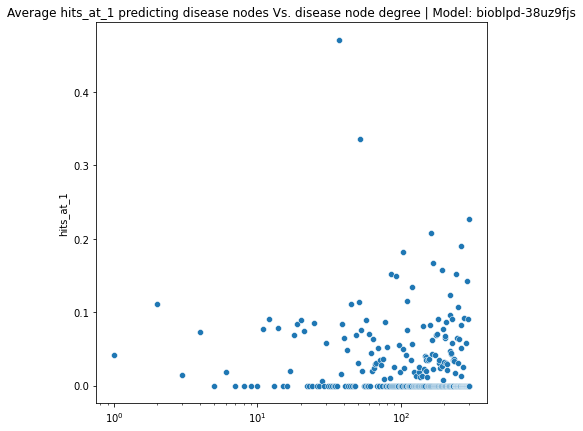

In [34]:
plot_metric_vs_degree_scatterplot_single_model(metric_name='hits_at_1', model_id=MODEL_ID,
                                    results_by_node_degree_dict=results_by_node_degree_dicts_bioblpdx)

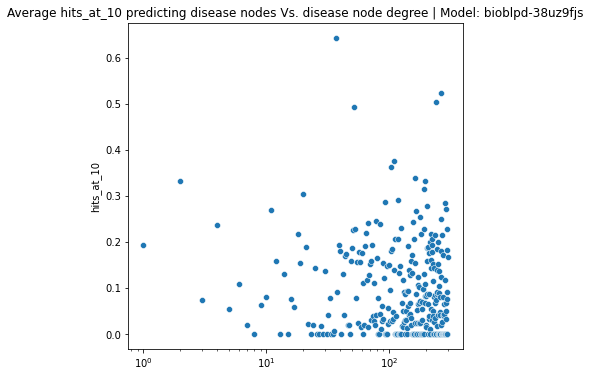

In [35]:
plot_metric_vs_degree_scatterplot_single_model(metric_name='hits_at_10', model_id=MODELS.get(BIOBLP_D),
                                    results_by_node_degree_dict=results_by_node_degree_dicts_bioblpdx,
                                              figsize=(6,6))

In [48]:
tags = {"model_name": MODEL_ID_bioblpd,
        "study_name": 'node_degree_trend',
        "test_set_type": TEST_RESTRICTED_DIS}
run = setup_wandb_result_tracker(**tags, project_name='bioblp-jupyter-trial', wandb_entity='discoverylab')

In [49]:
degrees, metrics = extract_relevant_metrics('hits_at_1', results_by_node_degree_dicts_bioblpdx)
data = [[x, y] for (x, y) in zip(degrees, metrics)]
table = wandb.Table(data=data, columns = ["degrees", "metrics"])
wandb.log({"bioblpd-hits_at_1_node_degree" : wandb.plot.scatter(table, "degrees", "metrics")})


In [144]:
import matplotlib.pyplot as plt
def plot_metric_vs_degree_scatterplot_multi_models(metric_name='hits_at_10', results_by_node_degree_dicts_combined=None):
    result_dfs = {}
    for model_id, result_dict in results_by_node_degree_dicts_combined.items():
        degrees, metrics = extract_relevant_metrics(metric_name, result_dict)
        result_dfs[model_id] = pd.DataFrame(np.column_stack([degrees, metrics]), columns=['degree', 'metrics'], dtype=float)
    model_ids = result_dfs.keys()
    print(model_ids)
    concatenated = pd.concat([result_dfs[model_id].assign(dataset=f'{model_id}') for model_id in model_ids])
    print(concatenated.head())
    plot, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(ax=ax, data=concatenated, x='degree', y='metrics', hue='dataset')
    plt.xscale('log')
    plt.ylabel(metric_name)
    plt.title(f'Average {metric_name} predicting disease nodes Vs. disease node degree | Model: {model_id}')
    #return degrees, metrics

#### RotatE

In [ ]:
MODEL_NAME_SLUG = ROTATE
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
eval_out_dir = Path(f"./metrics/{MODEL_ID}")
results_by_node_degree_rotate =  compute_metrics_over_triples_with_disease_tails(model_id=MODEL_ID,
                                                                                 test_triples_w_node_degree_df=test_triples_dis_df, 
                                                                                 test_set_slug=TEST_RESTRICTED_DIS)

loaded model from /home/jovyan/workbench-shared-folder/bioblp/models/rotate-otxtubeb


 70%|███████   | 212/301 [1:39:12<36:30, 24.62s/it]  

In [ ]:
results_by_node_degree_dicts_rotate = {}
for result in results_by_node_degree_rotate:
         results_by_node_degree_dicts_rotate[result['dis_degree']] = make_results_dict_all_rel(result['results'],
                                                                                relation=result['relation'],
                                                                                relation_count=result['count'],
                                                                                triple_endpoint='tail',
                                                                                metric_type='realistic'
                                                                               )


In [ ]:
with open(f'metrics/{MODEL_ID_rotate}/node-degree-eval-new.json', 'w+') as f:
    json.dump(results_by_node_degree_dicts_rotate, f)

load from file

In [47]:
MODEL_NAME_SLUG = ROTATE
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
eval_out_dir = Path(f"./metrics/{MODEL_ID}")

with open(eval_out_dir.joinpath('node-degree-eval.json'), 'r') as f:
    results_by_node_degree_dicts_rotate = json.load(f)


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [32]:
plot_metric_vs_degree_scatterplot_single_model(metric_name='hits_at_1', model_id=MODEL_ID,
                                    results_by_node_degree_dict=results_by_node_degree_dicts_rotate)

NameError: name 'results_by_node_degree_dicts_rotate' is not defined

/home/jovyan/.conda/envs/bioblp-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


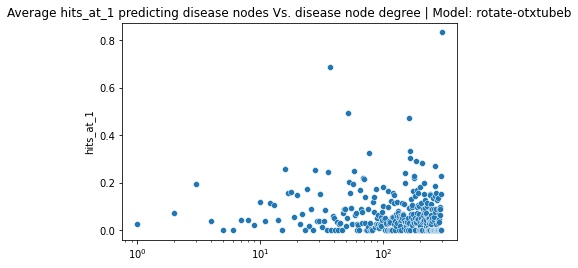

In [139]:
plot_metric_vs_degree_scatterplot_single_model(metric_name='hits_at_1', model_id=MODEL_ID,
                                    results_by_node_degree_dict=results_by_node_degree_dicts_rotate)

/home/jovyan/.conda/envs/bioblp-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


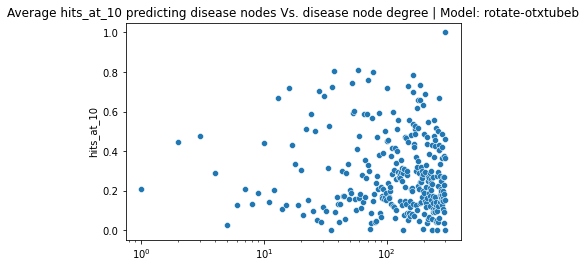

In [112]:
plot_metric_vs_degree_scatterplot_single_model(metric_name='hits_at_10', model_id=MODEL_ID,
                                    results_by_node_degree_dict=results_by_node_degree_dicts_rotate)

### combine into one graph

In [145]:
import matplotlib.pyplot as plt
def plot_metric_vs_degree_scatterplot_multi_models(metric_name='hits_at_10', results_by_node_degree_dicts_combined=None):
    result_dfs = {}
    for model_id, result_dict in results_by_node_degree_dicts_combined.items():
        degrees, metrics = extract_relevant_metrics(metric_name, result_dict)
        result_dfs[model_id] = pd.DataFrame(np.column_stack([degrees, metrics]), columns=['degree', 'metrics'], dtype=float)
    #model_ids = result_dfs.keys()
    concatenated = pd.concat([result_dfs[MODEL_ID_bioblpd].assign(dataset=f'{MODEL_ID_bioblpd}'),
                              result_dfs[MODEL_ID_rotate].assign(dataset=f'{MODEL_ID_rotate}')])
    plot, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(ax=ax, data=concatenated, x='degree', y='metrics', hue='dataset', style='dataset')
    plt.xscale('log')
    plt.ylabel(metric_name)
    plt.title(f'Average {metric_name} predicting disease nodes Vs. disease node degree | Model: {model_id}')
    #return degrees, metrics
    return concatenated

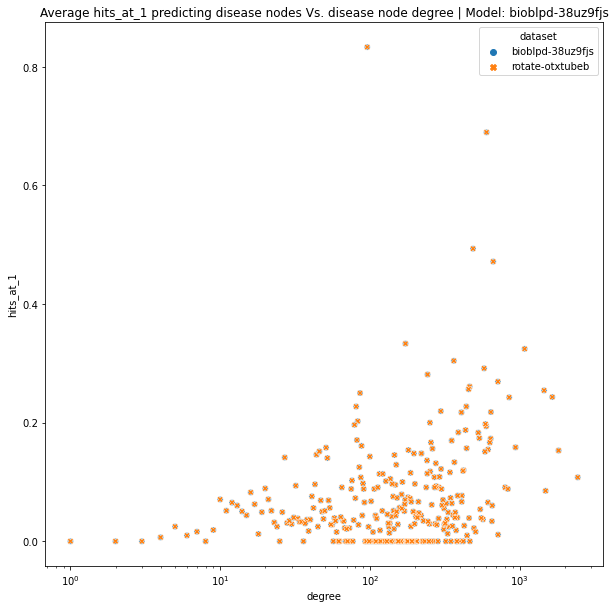

In [146]:
model_result_dicts = {MODEL_ID_rotate: results_by_node_degree_dicts_rotate,
                     MODEL_ID_bioblpd: results_by_node_degree_dicts_bioblpd}#results_by_node_degree_dicts_bioblp}
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name='hits_at_1', results_by_node_degree_dicts_combined=model_result_dicts)


In [204]:
#wandb.finish()

In [205]:
tags = {"model_name": MODELS.get(ROTATE),
        "study_name": 'node_degree_trend',
        "test_set_type": TEST_RESTRICTED_DIS}
run = setup_wandb_result_tracker(**tags, project_name='bioblp-jupyter-trial', wandb_entity='discoverylab')

In [187]:
degree_analysis_hits_at_10_bioblpd_path = "./data/imgs/node_analysis_hits_at_10_bioblpd.png"
degree_analysis_hits_at_1_bioblpd_path = "./data/imgs/node_analysis_hits_at_1_bioblpd.png"

wandb.log({"hits@10_bioblpd": wandb.Image(degree_analysis_hits_at_10_bioblpd_path)})
wandb.log({"hits@1_bioblpd": wandb.Image(degree_analysis_hits_at_1_bioblpd_path)})

## 

In [188]:
test_entity_split_by_disease_descr_path = "./data/imgs/eval_split_entity_view.png"
test_triples_split_by_disease_descr_path = "./data/imgs/eval_split_triples_view.png"
wandb.log({"Split test set entities conditioned on entity having properties with text modality": wandb.Image(test_entity_split_by_disease_descr_path)})
wandb.log({"Split test set triples conditioned on having node entities with properties of text modality": wandb.Image(test_triples_split_by_disease_descr_path)})

In [206]:
degree_analysis_hits_at_10_rotate_path = "./data/imgs/node_analysis_hits_at_10_rotate.png"
degree_analysis_hits_at_1_rotate_path = "./data/imgs/node_analysis_hits_at_1_rotate.png"

wandb.log({"hits@10_rotate": wandb.Image(degree_analysis_hits_at_10_rotate_path)})
wandb.log({"hits@1_rotate": wandb.Image(degree_analysis_hits_at_1_rotate_path)})

## archived

### previous stuff

How do MRR, H@k, and AMR correlate?

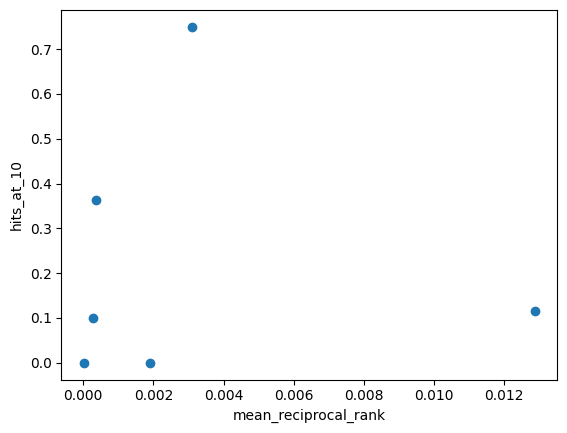

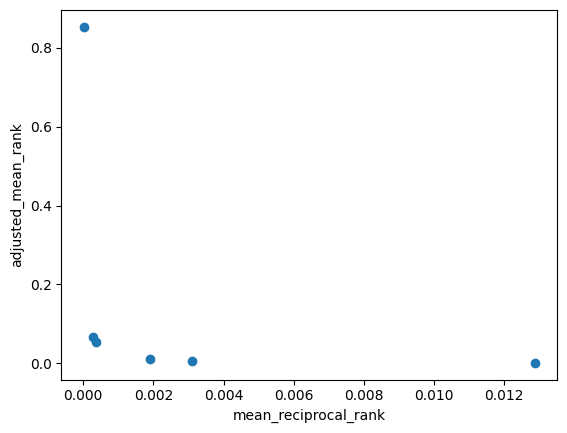

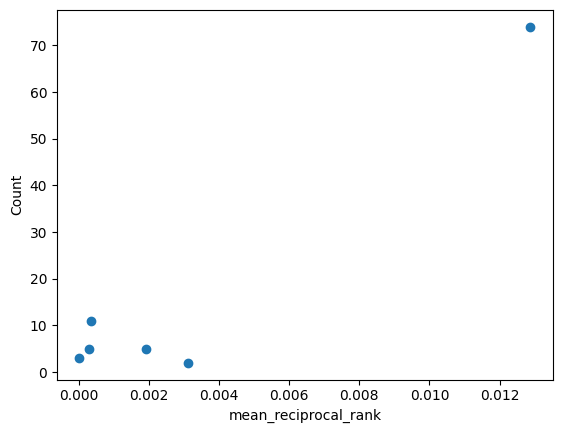

In [32]:
def plot_metric_pair(results_df, metric_1: str, metric_2: str):
    """Make a scatter plot with one link prediction metric in each axis."""
    plt.figure()
    plt.scatter(results_df[metric_1], results_df[metric_2])
    plt.xlabel(metric_1)
    plt.ylabel(metric_2)

plot_metric_pair(results_df, 'mean_reciprocal_rank', 'hits_at_10')
plot_metric_pair(results_df, 'mean_reciprocal_rank', 'adjusted_mean_rank')
plot_metric_pair(results_df, 'mean_reciprocal_rank', 'Count')

What are the relations where the model performs better?

In [33]:
def per_relation_plot(results_df, metric: str):
    """Make a bar plot of link prediction performance for each relation."""
    results_df[['Relation', metric]].sort_values(by=metric).plot.barh(x='Relation', figsize=(5, 5), grid=True)

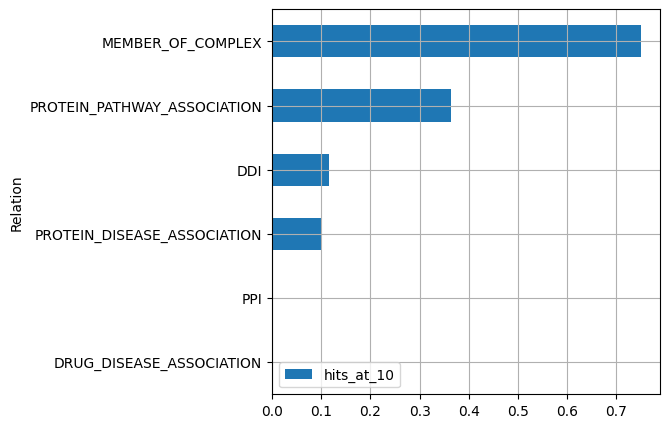

In [34]:
per_relation_plot(results_df, 'hits_at_10')

### Evaluating over specific entity and relation types
The source csv files contain the triples, plus extra information like the types of the entities involved in the triple. We will extract the type information.

We can see that restricting predictions over the correct domain and range of a relation only slightly increases the results.

In [ ]:
can you do an. analysis on degree....
compare rotate to this